In [84]:
import numpy as np
import random
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [85]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [86]:
#條誇號參數絕定其error
noise_model = get_noise(0.01)

In [87]:
#the oracle that flips the output qubit if 
#1. 選的行或列已包含了所有星星 (oracle 1)
#2. control qubit 為 1 的個數為 3 (oracle 2)
#如何使用此 oracle見下面 example


def plus_one(n, c2):
    qc.mct([input_qubits[n], numof1_qubits[0], numof1_qubits[1]], check_qubits2[c2])
    qc.ccx(input_qubits[n], numof1_qubits[1], numof1_qubits[0])
    qc.cx(input_qubits[n], numof1_qubits[1])

def plus_one_r(n, c2):
    qc.cx(input_qubits[n], numof1_qubits[1])
    qc.ccx(input_qubits[n], numof1_qubits[1], numof1_qubits[0])
    qc.mct([input_qubits[n], numof1_qubits[0], numof1_qubits[1]], check_qubits2[c2])
    
    
def oracle(qc, clause_list):


    #Oracle1: 
    i = 0
    for clause in clause_list:
        qc.cx(input_qubits[clause[0]], check_qubits1[i])
        qc.cx(input_qubits[clause[1]], check_qubits1[i])
        qc.ccx(input_qubits[clause[0]], input_qubits[clause[1]], check_qubits1[i])
        #qc.barrier()
        i += 1
    qc.barrier()

    #Oracle2
    #initialize check_qubits2 to 1
    for k in range(5):
        qc.x(check_qubits2[k])
        
    qc.cx(input_qubits[0], numof1_qubits[1])
    #qc.barrier()
    qc.ccx(input_qubits[1], numof1_qubits[1], numof1_qubits[0])
    qc.cx(input_qubits[1], numof1_qubits[1])
    #qc.barrier()
    qc.ccx(input_qubits[2], numof1_qubits[1], numof1_qubits[0])
    qc.cx(input_qubits[2], numof1_qubits[1])
    #qc.barrier()

    for i in range(3,7+1):
        plus_one(i, i-3)
        #qc.barrier()
    qc.barrier()

    #output to target qubit
    check_qubits1list = []
    for i in range(len(clause_list)):
        check_qubits1list.append(check_qubits1[i])

    check_qubits2list = []
    for i in range(5):
        check_qubits2list.append(check_qubits2[i])

    qc.mct(check_qubits1list + [numof1_qubits[0], numof1_qubits[1]] + check_qubits2list, output_qubit[0] )

    qc.barrier()

    #Oracle1(reverse)

    i = 0
    for clause in clause_list:
        qc.cx(input_qubits[clause[0]], check_qubits1[i])
        qc.cx(input_qubits[clause[1]], check_qubits1[i])
        qc.ccx(input_qubits[clause[0]], input_qubits[clause[1]], check_qubits1[i])
        #qc.barrier()
        i += 1
    
    qc.barrier()
    #Oracle2(reverse)
    
    for i in range(7, 3-1, -1):
        plus_one_r(i, i-3)
        #qc.barrier()

    qc.cx(input_qubits[2], numof1_qubits[1])
    qc.ccx(input_qubits[2], numof1_qubits[1], numof1_qubits[0])
    #qc.barrier()
    qc.cx(input_qubits[1], numof1_qubits[1])
    qc.ccx(input_qubits[1], numof1_qubits[1], numof1_qubits[0])
    #qc.barrier()
    qc.cx(input_qubits[0], numof1_qubits[1])
    #qc.barrier()
    
    #turn check_qubits2 back to 0
    for k in range(5):
        qc.x(check_qubits2[k])
        
def diffuser(qc,n):

    for i in range(n):
        qc.h(input_qubits[i])

    for i in range(n):
        qc.x(input_qubits[i])

    qc.h(n-1)
    qc.mct(input_qubits[0:7], n-1)
    qc.h(n-1)

    for i in range(n):
        qc.x(input_qubits[i])

    for i in range(n):
        qc.h(input_qubits[i])

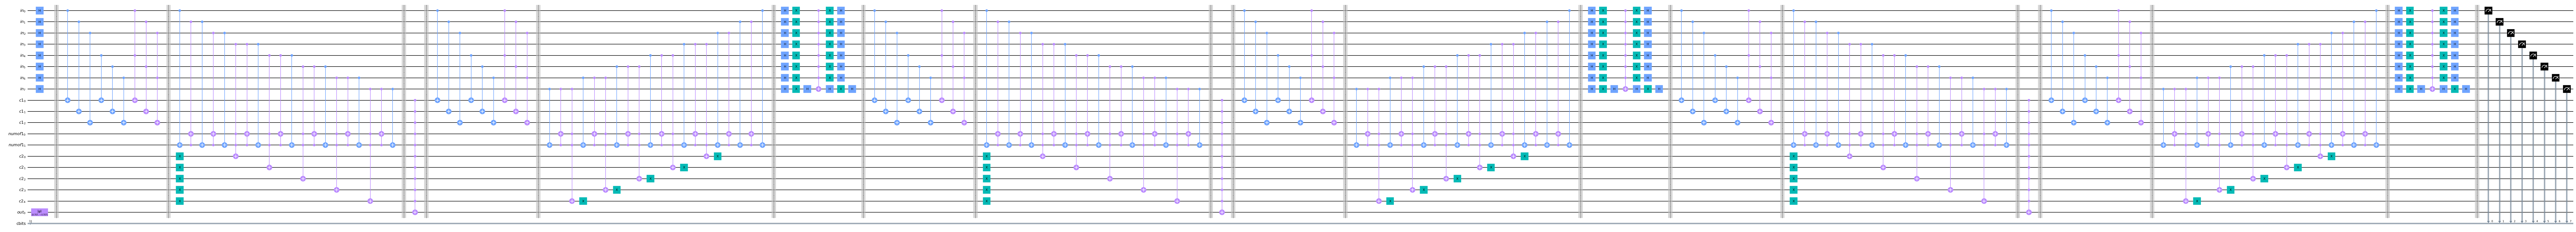

In [88]:
#an example of using this oracle (可以自己改不同數字來測試)
#clause_list = [[0,4],[1,5],[2,6],[3,7]]
#clause_list = [[0,4],[1,5],[2,6],[2,4],[0,6],[1,7]]
clause_list = [[0,4],[1,5],[2,6]] 

#0,1,2,3 就是 1,2,3,4列 ，4,5,6,7就是 1,2,3,4行，像是 [1,5]就代表一個星星在第二行第二列的位置
#注: 除了 input qubits 和 output qubits，這個 oracle需要一些 auxiliary qubits，其中 oracle 1 需要用到 check_qubits1 (看有幾個星星就幾個qubits)
#而 oracle 2 需要用到 2(numof1_qubits) + 5(check_qubits2) 個 qubits
#使用這個 oracle 時只要如下5行initialize這些auxiliary qubits，oracle就可正常運作。(名字記得取一樣的) 
input_qubits = QuantumRegister(8, name='in')
check_qubits1 = QuantumRegister(len(clause_list), name='c1')
numof1_qubits = QuantumRegister(2, name = 'numof1')
check_qubits2 = QuantumRegister(5, name = 'c2')
output_qubit = QuantumRegister(1, name = 'out')

top_n = 10

#這行以下為測試此oracle是否正確
cbits = ClassicalRegister(8+len(clause_list), name = 'cbits')
qc = QuantumCircuit(input_qubits, check_qubits1, numof1_qubits, check_qubits2, output_qubit, cbits)
qc.initialize([1, -1]/np.sqrt(2), output_qubit)
for i in range(8):
    qc.h(input_qubits[i])
qc.barrier()


# 假設取第1,2,3列，檢查是否涵蓋所有星星
#qc.x(input_qubits[0])
#qc.x(input_qubits[1])
#qc.x(input_qubits[2])
#qc.x(node_qubits[3])
#qc.barrier()

#理論上要取(2^8)^0.5 = 16以內的整數，這裡取8以內的
#xx = random.randint(0, 8)

#確認用,測試改回random
xx = 3

for jj in range(xx):
    oracle(qc, clause_list)
    qc.barrier()

    diffuser(qc,8)
    qc.barrier()

#repeat
#oracle(qc, clause_list)
#qc.barrier()

#diffuser(qc,8)
#qc.barrier()

#i=0

#while i < len(clause_list):
#    qc.measure(check_qubits1[i], i)
#    i += 1

#qc.measure(numof1_qubits[0],i)
#i += 1
#qc.measure(numof1_qubits[1],i)
#i += 1

#for j in range(5):
#    qc.measure(check_qubits2[j], i) 
#    i += 1

#qc.measure(output_qubit[0], i)

i=0

while i < 8:
    qc.measure(input_qubits[i], i)
    i += 1

qc.draw(output='mpl', fold=-1)

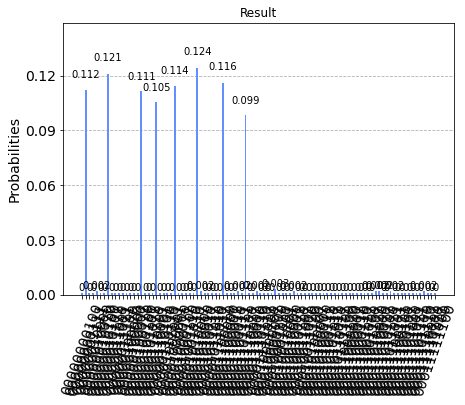

In [89]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(qc, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer, title="Result")

In [78]:
print(answer)

{'00010101111': 1, '00011000100': 1, '00001001001': 1, '00001010111': 1, '00000001010': 1, '00011101000': 1, '00001001111': 1, '00010100010': 1, '00011001001': 1, '00011011001': 2, '00010110111': 1, '00001101101': 1, '00010001001': 2, '00010111011': 1, '00000000010': 1, '00010011110': 1, '00000101101': 2, '00011000010': 1, '00011000111': 1, '00011110101': 1, '00001100100': 1, '00010111000': 1, '00001100010': 2, '00010010011': 1, '00001000101': 3, '00000100111': 1, '00010110000': 5, '00011111011': 1, '00000110111': 3, '00011010011': 6, '00010100111': 2, '00001000111': 2, '00001101001': 1, '00000101110': 2, '00000101001': 2, '00010110100': 2, '00000011100': 1, '00010010010': 1, '00000001011': 5, '00001111110': 4, '00000001110': 4, '00010001100': 3, '00010111101': 2, '00010111100': 2, '00001000000': 1, '00011011100': 1, '00010001111': 2, '00001110001': 5, '00010101101': 1, '00000100000': 1, '00001100000': 2, '00000101111': 1, '00011010100': 2, '00000011111': 2, '00011001000': 1, '00000010

[['00001010010', 127], ['00000010110', 124], ['00001100001', 119], ['00001000011', 117], ['00000000111', 115], ['00000100101', 114], ['00000110100', 108], ['00001110000', 101], ['00010001001', 3], ['00001101100', 2], ['00000010010', 2], ['00010010101', 2], ['00011011111', 2], ['00011110000', 2], ['00011010100', 2], ['00001110111', 2], ['00001010011', 2], ['00011010011', 2], ['00001111101', 1], ['00000100100', 1], ['00010000000', 1], ['00010100111', 1], ['00011101001', 1], ['00000011100', 1], ['00011101100', 1], ['00010101010', 1], ['00010010010', 1], ['00010110100', 1], ['00000100000', 1], ['00000101101', 1], ['00010111110', 1], ['00001100111', 1], ['00011001110', 1], ['00000011011', 1], ['00000110110', 1], ['00010011010', 1], ['00010111100', 1], ['00001000110', 1], ['00001000100', 1], ['00011011001', 1], ['00010000110', 1], ['00011100101', 1], ['00001101111', 1], ['00010010001', 1], ['00001011011', 1], ['00000011110', 1], ['00011000110', 1], ['00001010000', 1], ['00011111000', 1], ['0

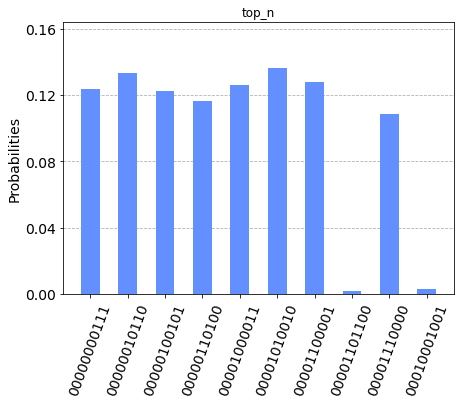

In [90]:
p1 = []
p2 = []
pause = results.get_counts()
pause.clear()
di = dict.fromkeys(answer)
for i in di.keys():
    p1.append([i,answer.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)

In [91]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots = 1000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
noisy_counts = results.get_counts()
print(noisy_counts)
"""qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(qc, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer, title="Result")"""

{'00000010111': 1, '00011101111': 1, '00000110110': 2, '00010111100': 1, '00001111010': 1, '00000010011': 1, '00001101001': 1, '00000001011': 1, '00011100111': 1, '00000000100': 1, '00000111111': 1, '00011010010': 1, '00010011111': 1, '00011111111': 1, '00000000010': 1, '00010100110': 1, '00010011101': 1, '00001000100': 1, '00011001001': 1, '00011001111': 1, '00000010100': 6, '00001100100': 1, '00011001100': 2, '00001010110': 5, '00001110000': 107, '00010101100': 3, '00001000101': 1, '00011111110': 2, '00001010100': 2, '00010110011': 1, '00001111011': 1, '00001111000': 2, '00000001001': 1, '00001110010': 2, '00001110011': 1, '00011000011': 1, '00011011000': 1, '00010000001': 1, '00010001001': 1, '00011100000': 1, '00011111100': 1, '00000010000': 1, '00001111111': 1, '00001110100': 1, '00000110100': 134, '00011111011': 1, '00010000111': 1, '00000110000': 1, '00001100001': 82, '00010110001': 1, '00001000011': 116, '00000100101': 113, '00000000111': 93, '00010101011': 1, '00001100000': 2,

'qasm_sim = Aer.get_backend(\'qasm_simulator\')\ntranspiled_dj_circuit = transpile(qc, qasm_sim)\nqobj = assemble(transpiled_dj_circuit)\nresults = qasm_sim.run(qobj).result()\nanswer = results.get_counts()\nplot_histogram(answer, title="Result")'

[['00000110100', 134], ['00001000011', 116], ['00000100101', 113], ['00001110000', 107], ['00001010010', 99], ['00000000111', 93], ['00000010110', 93], ['00001100001', 82], ['00000010100', 6], ['00001100011', 6], ['00001010110', 5], ['00000100100', 4], ['00001100101', 4], ['00001010000', 4], ['00000000110', 4], ['00011110000', 4], ['00010010110', 4], ['00010101100', 3], ['00000010010', 3], ['00001110001', 3], ['00000101010', 3], ['00000101101', 3], ['00000110110', 2], ['00011001100', 2], ['00011111110', 2], ['00001010100', 2], ['00001111000', 2], ['00001110010', 2], ['00001100000', 2], ['00000001111', 2], ['00010100011', 2], ['00000001101', 2], ['00011100001', 2], ['00011110001', 2], ['00011111000', 2], ['00001000001', 2], ['00010100101', 2], ['00000000101', 2], ['00000011000', 2], ['00001101000', 2], ['00000010111', 1], ['00011101111', 1], ['00010111100', 1], ['00001111010', 1], ['00000010011', 1], ['00001101001', 1], ['00000001011', 1], ['00011100111', 1], ['00000000100', 1], ['00000

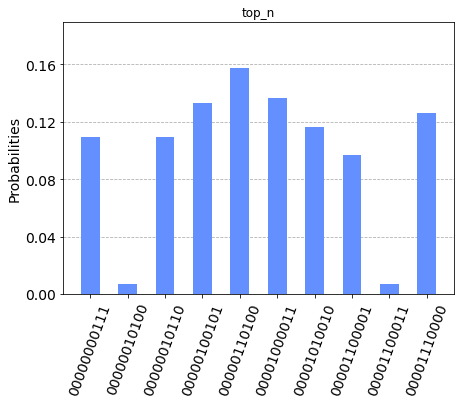

In [92]:
p3 = []
p4 = []
pause2 = results.get_counts()
pause2.clear()
di = dict.fromkeys(noisy_counts)
for i in di.keys():
    p3.append([i,noisy_counts.get(i)])
p3.sort(key = lambda s: s[1],reverse = True)
print(p3)
for i in range(top_n):
        b = p3[i]
        pause2.setdefault(b[0],b[1])
plot_histogram(pause2, title="top_n",bar_labels = False)

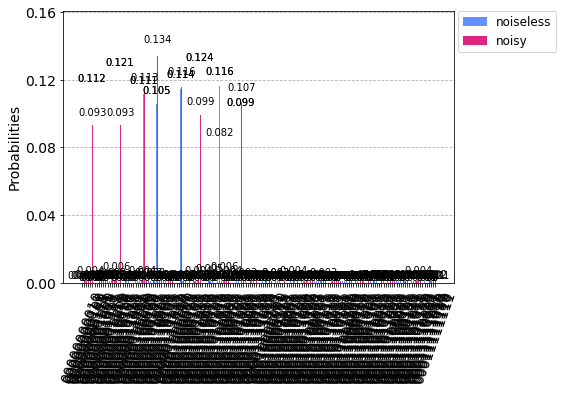

In [93]:
plot_histogram([answer, noisy_counts], legend=['noiseless', 'noisy'])

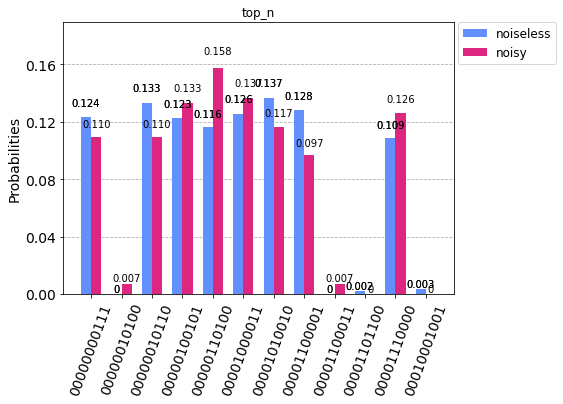

In [94]:
plot_histogram([pause, pause2], title="top_n", legend=['noiseless', 'noisy'])